# EAA Winter School in Computational Acoustics 2018


## Direct responses calculation

In the first practice, only Neuman conditions (nullity of the normal derivative of the function) and mode computations were considered. The objective of this tutorial is to study how to implement other boundary conditions and to compute direct responses. It corresponds to the worked example proposed in the section 2 of the lecture.


In [327]:
import numpy as np
import matplotlib.pyplot as plt

In [328]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=14)
mpl.rc('axes', linewidth=1.5, labelsize=14)
mpl.rc('legend', fontsize=14)

Assignation of some  constants

In [329]:
j = np.sqrt(np.complex(-1.,0))
c_0 = 340; rho_0 = 1.2; Z_0= rho_0*c_0 # Medium parameters
L = 1 # Dimension of the tube
Up=1 # Value of the imposed velocity

We will consider harmonic excitation with the convention $e^{j\omega t}$ where $j=\sqrt{-1}$ and $\omega=2\pi f$ is the circular frequency imposed by the source which oscillates at frequency $f$. The  analytical solution in the tube can be written as the superposition of a forward and a backward wave:
$$ p(x)=\alpha e^{-jkx}+\beta e^{jkx}.$$
where $k=\omega/c$ is the wave number. $\alpha$ and $\beta$ are the two unknown amplitudes which can be determined with the help of boundary conditions.

On the left of the tube $(x=-L)$, an velocity $U_p$ is imposed:
$p'(-L)=-jkZ_0 U_p$. On the right ($x=0$) we have an admitance condition $p'(0)=-jkAp(0)$, where $A$ is the admitance of the termination.

The relation between $\alpha$ and $\beta$ in $x=-L$ leads to:
$$ \Big(\alpha e^{jkL}-\beta e^{-jkL}\Big)=Z_0U_p,\quad .$$
The admitance relation in $x=0$ is:
$$\alpha-\beta=A(\alpha+\beta)$$
The values of $\alpha$ and $\beta$ are then:
$$ \alpha=\dfrac{Z_0U_p(1+A)}{(1+A)e^{jkL}+(1-A)e^{-jkL}},\quad \beta=\dfrac{1-A}{1+A}\alpha.$$

In [330]:
def analytical_solution(k,L,A=1,x=np.linspace(-L,0,500)):
    alpha = Z_0*Up*(1+A)/((1+A)*np.exp(j*k*L)+(1-A)*np.exp(-j*k*L))
    beta = alpha *(1-A)/(1+A)
    p = alpha*np.exp(-j*k*x)+beta*np.exp(j*k*x)
    p = p.reshape((x.size,1))
    return x,p

The weak form associated to this problem is remained: 
$$ 
\forall q\in V,\quad \Big[
p'(x)q(x)
\Big]_{-L}^0 - \displaystyle{\int_{-L}^0} p'(x)q'(x)dx + \dfrac{\omega^2}{c_0^2} \displaystyle{\int_{-L}^0} p(x)q(x)dx =0 
$$
For the considered boundary conditions, we have: 
$$ 
\forall q\in V,\quad 
  \displaystyle{\int_{-L}^0} p'(x)q'(x)dx - \dfrac{\omega^2}{c_0^2} \displaystyle{\int_{-L}^0} p(x)q(x)dx =-jkAp(0)q(0)-jkZ_0U_pq(-L)
.$$

The term relative to the excitation ($x=-L$) is associated to the first degree of freedom. We can rewrite it as:
$$ q(-L) = \{q_0,\, ... ,\, q_{-1}\}\underbrace{\begin{Bmatrix}
1\\
0\\
\\
0
\end{Bmatrix}}_{\bf{F}}$$
Similarly, for the $x=0$, we can introduce a global matrix $[\bf{C}]$ for which all entries are zero except one the last line and last column. We have:
$$ q(0)p(0) = \{q_0,\, ... ,\, q_{-1}\}\underbrace{\begin{bmatrix}
0 & ...& 0\\
0 & ...&0\\
0 & ... & 1
\end{bmatrix}}_{[\bf{C}]}
\underbrace{\begin{Bmatrix}
p_0\\
0\\
\\
p_{-1}
\end{Bmatrix}}_{\bf{p}}$$
The discretised system is then:
$$ \Big([\bf{K}]+j\omega A 
[\bf{C}]-\omega^2
[\bf{M}]\Big)\bf{p}=\rho_0j\omega U_p\bf{F}$$

The functions to build the mass and stiffness elementary matrices for linear and quadratic elements are the same than in the previous tutorial. They are:

In [331]:
def K_e_lin(delta):
    return (1/delta)*np.array([[1.,-1.],[-1.,1.]])

def M_e_lin(delta):
    return (delta/(6.*c_0**2))*np.array([[2.,1.],[1.,2.]])

def K_e_quad(delta):
    return (1/(3*delta))*np.array([[7.,-8.,1],[-8.,16.,-8],[1.,-8.,7]])

def M_e_quad(delta):
    return (delta/(30.*c_0**2))*np.array([[4.,2.,-1],[2.,16.,2],[-1,2,4]])

The global matrices and vectors are:

In [332]:
def assembly_global_matrices_lin(n):
    delta = L/n
    K =np.zeros((n+1,n+1))
    C =np.zeros((n+1,n+1))
    M =np.zeros((n+1,n+1))
    F =np.zeros((n+1,1))
    
    for ie in range(n): # loop on the elements
        dof = slice(ie, ie+2) # indices of the local dofs
        K[dof,dof] += K_e_lin(delta)
        M[dof,dof] += M_e_lin(delta)
    C[-1,-1] = 1 / c_0
    F[0] = 1
    return K,C,M,F

def assembly_global_matrices_quad(n):
    delta = L/n
    K =np.zeros((2*n+1,2*n+1))
    C =np.zeros((2*n+1,2*n+1))
    M =np.zeros((2*n+1,2*n+1))
    F =np.zeros((2*n+1,1))
    
    for ie in range(n): # loop on the elements
        dof = slice(2*ie, 2*ie+3) # indices of the local dofs
        K[dof,dof] += K_e_quad(delta)
        M[dof,dof] += M_e_quad(delta)
    C[-1,-1] = 1 / c_0
    F[0] = 1
    return K,C,M,F

def compute_FEM_solution(omega,A,K,C,M,F):
    x = np.linspace(-L,0,F.size)
    A = K+j*omega*A*C-omega**2*M
    b = rho_0*j*omega*Up*F
    p = np.linalg.solve(A,b)
    return x,p


We can then compute the direct response for the examples presented in the lecture of this morning:

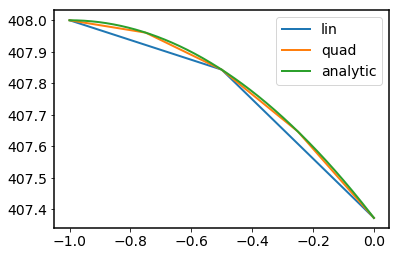

In [333]:
# Physical parameters
f = 3 ; omega =2*np.pi*f
k = omega/c_0
A =1

# Number of elements
n=2
# Computation of the analytical solution
x_analytic, p_analytic=analytical_solution(k,L,A)



# Computation for the case of linear elements
K_lin,C_lin,M_lin,F_lin = assembly_global_matrices_lin(n)
x_lin,p_lin = compute_FEM_solution(omega,A,K_lin,C_lin,M_lin,F_lin)

# Computation for the case of quadratic elements
K_quad,C_quad,M_quad,F_quad = assembly_global_matrices_quad(n)
x_quad,p_quad = compute_FEM_solution(omega,A,K_quad,C_quad,M_quad,F_quad)

# Figures
plt.figure()
plt.plot(x_lin,p_lin.real, label='lin')
plt.plot(x_quad,p_quad.real, label='quad')
plt.plot(x_analytic,p_analytic.real, label='analytic')
plt.legend()
plt.show()

><div class="alert alert-block alert-info">
Modify the value of $n$ to investigate qualitatively the convergence of linear and quadratic elements

We can compute the error of the method by using the discretisation of the $L^2$ norm:
    $$ \sqrt{\displaystyle{\int_{-L}^0}  \,|p_{ref}-p_{num}|^2 \,dx}\approx \sqrt{\boldsymbol{\epsilon}^H[\boldsymbol{M}]\boldsymbol{\epsilon}},$$
    where $\boldsymbol{\epsilon}$ is the vector of the difference between the analytical and FEM nodal values.
    
    
    

In [335]:
def error_lin(n):
    K,C,M,F = assembly_global_matrices_lin(n)
    x,p = compute_FEM_solution(omega,A,K,C,M,F)
    x_ref, p_ref=analytical_solution(k,L,A,x)
    eps = p_ref-p
    temp = M@eps
    error = np.absolute(np.conj(eps.T)@eps)
    ref = np.absolute(np.conj(p_ref.T@M)@p_ref)
    return np.sqrt(error[0,0]/ref[0,0])


def error_quad(n):
    K,C,M,F = assembly_global_matrices_quad(n)
    x,p = compute_FEM_solution(omega,A,K,C,M,F)
    x_ref, p_ref=analytical_solution(k,L,A,x)
    eps = p_ref-p
    temp = M@eps
    error = np.absolute(eps.T@eps)
    ref = np.absolute(np.conj(p_ref.T@M)@p_ref)
    
    return np.sqrt(error[0,0]/ref[0,0])

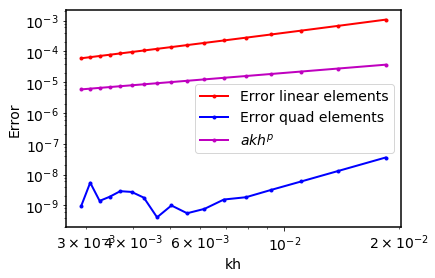

In [337]:
n_max = 20
kh=np.zeros(n_max)
eps_lin=np.zeros(n_max)
eps_quad=np.zeros(n_max)

for i_n in range(3,n_max):
    kh[i_n] = k*L/i_n
    eps_lin[i_n]=error_lin(i_n)
    eps_quad[i_n]=error_quad(i_n)
    
plt.figure()
plt.loglog(kh,eps_lin,'r.-',label='Error linear elements')
plt.loglog(kh,eps_quad,'b.-',label='Error quad elements')
a = 0.002
p = 1
plt.loglog(kh,a*kh**p,'m.-',label='$akh^p$')
plt.xlabel('kh') ; plt.ylabel('Error')
plt.legend()
plt.show()